# Exploratory Data Analysis
### Sepsis Prediction
#### Data Analysis and Visualization Lab - Spring 2022<br>
Omer Nahum , Omer Madmon

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

np.random.seed(2)

A single patient $i$ is represented by a $T_i*F$ matrix, where $T_i$ is the number of timesteps recorded for the i'th patient, and $F$ is the number of features (fixed across all patients).

In [47]:
filepath = 'data/train/patient_0.psv'
data = pd.read_csv(filepath, delimiter='|')
data.head(10)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,1,0
1,61.0,99.0,36.44,124.0,65.0,43.0,17.5,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,2,0
2,64.0,98.0,NaN,125.0,64.0,41.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,3,0
3,56.0,100.0,NaN,123.0,65.0,41.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,4,0
4,66.0,99.0,NaN,120.0,67.0,43.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,5,0
5,94.0,100.0,36.22,194.0,116.0,66.0,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,6,0
6,58.0,99.0,NaN,133.0,68.0,43.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,7,0
7,57.0,100.0,NaN,118.0,62.0,37.0,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,8,0
8,62.0,100.0,NaN,126.0,66.0,37.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,9,0
9,58.0,95.0,36.11,143.0,77.0,47.0,11.0,NaN,NaN,22.0,...,11.0,NaN,158.0,75.91,0,0,1,-98.6,10,0


The last column ("SepsisLabel") is a target column, whereas all others are features.<br>
We devide the 40 features into 3 main feature-groups:
* Vital Signs
* Lab Values
* Demographic

We will further address these groups separately, as they tend to share many properties.

In [3]:
columns = data.columns
vital_signs_columns = columns[:8]
lab_values_columns = columns[8:34]
demographic_columns = columns[34:40]

Load all patients' psv files:

In [4]:
dirpath = 'data/train'

n_patients = 0
n_records = 0
data = list()
pateint_ids = list()

for filename in tqdm(os.listdir(dirpath)):
    pateint_ids.append(filename.split('.')[0])
    filepath = dirpath + '/' + filename
    df = pd.read_csv(filepath, delimiter='|')
    data.append(df)
    
    n_patients += 1
    n_records += df.shape[0]

100%|████████████████████████████████████| 20000/20000 [02:05<00:00, 159.33it/s]


In [9]:
print(f'Number of patients: {n_patients}')
print(f'Number of records: {n_records}')
print(f'Mean Number of records per patient: {n_records / n_patients}')

Number of patients: 20000
Number of records: 766884
Mean Number of records per patient: 38.3442


### Missing Data
In the following cells we intend to check the precentage of NaNs overall in the data, and specifically per paetient,<br>
in order to better understand the missingness properties of our features, and decide on imputation and features selection methods.

In [5]:
nan_overall = pd.Series(data=[0]*len(columns), index=columns)
nan_per_patient = pd.DataFrame(columns=columns)

for df in tqdm(data):
    nan_overall += df.isna().mean()
    nan_per_patient = pd.concat([nan_per_patient, pd.DataFrame(df.isna().mean()).T])
nan_per_patient.index = pateint_ids

100%|████████████████████████████████████| 20000/20000 [03:15<00:00, 102.55it/s]


In the following plots, for each group of features (as described above) we visualize boxplots of missing values distributions across patients. In other words, for each feature $j$ we created a vector (of number-of-patients length), where the i'th entry in this vector will be the precentage of missing values of patient $i$ in feature $j$, and then we plot the distribution for each feature.

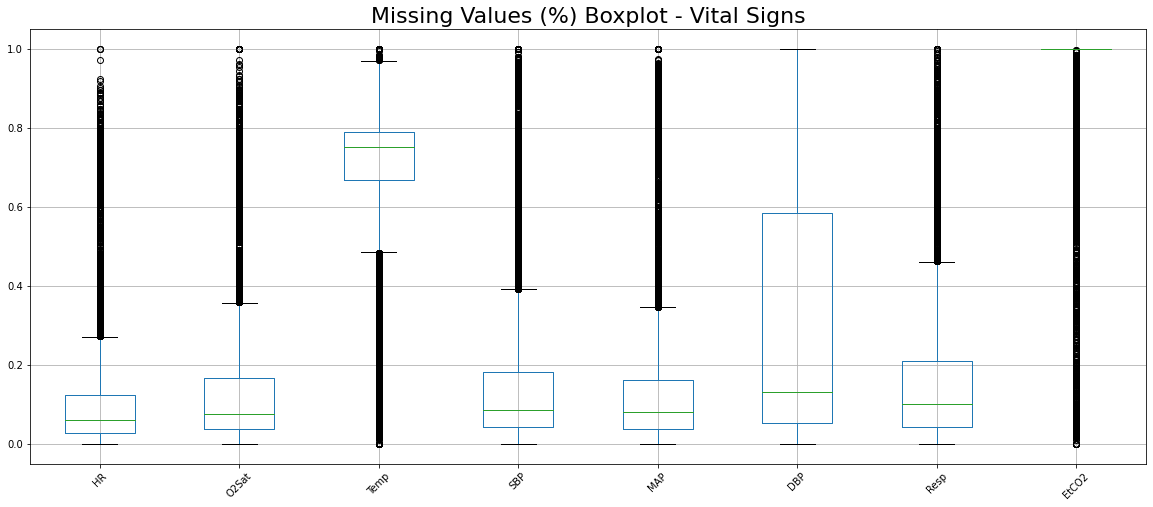

In [6]:
plt.figure(figsize=(20,8))
nan_per_patient[vital_signs_columns].astype(float).boxplot()
plt.xticks(range(1, len(vital_signs_columns) + 1), vital_signs_columns, rotation=45)
plt.title('Missing Values (%) Boxplot - Vital Signs', fontsize=22)
plt.show()

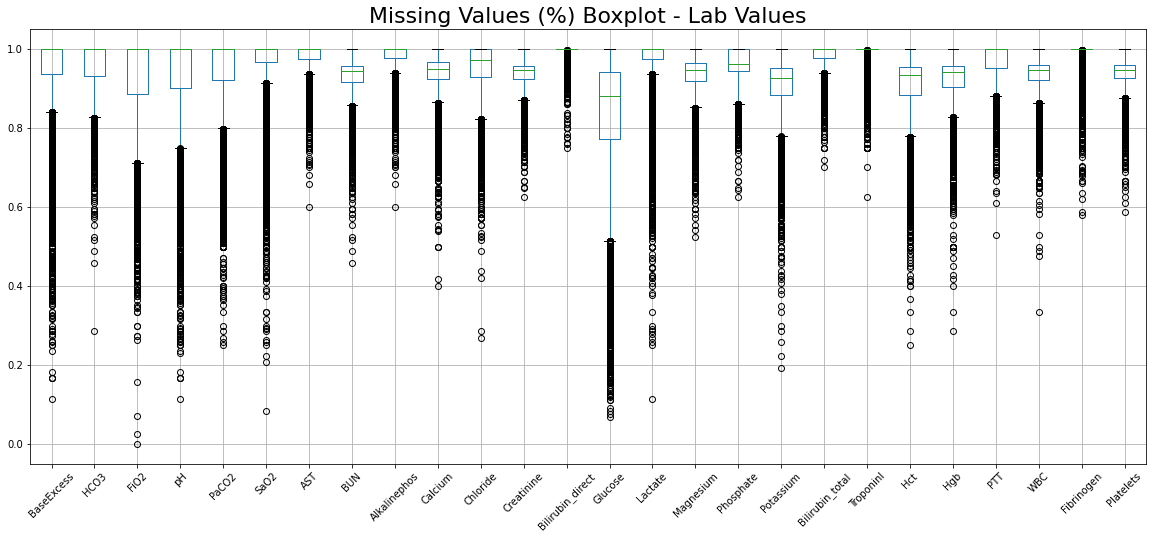

In [7]:
plt.figure(figsize=(20,8))
nan_per_patient[lab_values_columns].astype(float).boxplot()
plt.xticks(range(1, len(lab_values_columns) + 1), lab_values_columns, rotation=45)
plt.title('Missing Values (%) Boxplot - Lab Values', fontsize=22)
plt.show()

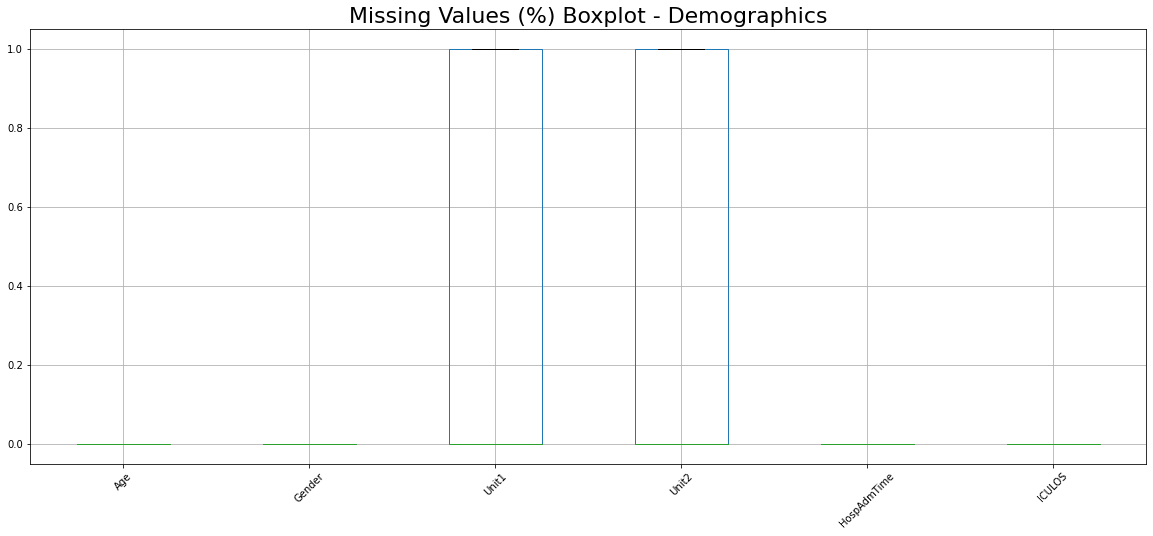

In [8]:
plt.figure(figsize=(20,8))
nan_per_patient[demographic_columns].astype(float).boxplot()
plt.xticks(range(1, len(demographic_columns) + 1), demographic_columns, rotation=45)
plt.title('Missing Values (%) Boxplot - Demographics', fontsize=22)
plt.show()

From these plots we can clearly observe different missing value propery for each group:
* For most vital signs features, most patients have low precentage of missing value (this can be seen by the location of the box). Vital signs are frequently measured among patients, and therefore as expected have low precentage of missing data.
* For most lab values, the picture is opposite, where most patients have high precentage of missing values. There are 26 different lab values recorded in this dataset (and many more in reality), and these are taken for specific patietns in specific timesteps. Therefore, a high precentage of missing values is expected. Although we barely observe these features for most patients, the exsistence of such features can indicate that a doctor found this lab test important in this timestep.
* For the demographic features, except Unit1 and Unit2, we see that we have (almost) no missing values.

## Descriptive Statistics
Analyse distribution of features.

In [10]:
labels = []
for df in data:
    labels.append(int(np.any(df['SepsisLabel'] == 1)))
labels = np.array(labels)

In [11]:
p = 100 * labels.mean()
print(f'Precentage of Sepsis-diagnosed: {p:.3f}%')

Precentage of Sepsis-diagnosed: 7.075%


First observation: data is highly imbalanced. Therefore, our evaluation metrics will have to take this into consideration. We will also prefer to weight our classes when using a classification model.

In [24]:
n = len(data)
indices = np.random.choice(range(n), replace=False, size=n // 4)
sample_data = [data[i] for i in indices]
sample_labels = labels[indices]

concat_data = [pd.DataFrame(columns=columns),
               pd.DataFrame(columns=columns)]

for df, label in tqdm(zip(sample_data, sample_labels)):
    concat_data[label] = pd.concat([concat_data[label], df])

5000it [03:10, 26.20it/s]


We created a single dataframe, containing all timesteps from a sample of patients (25% of all patients).<br>
We will analyse features in this flattened form, instead of per-patient analysis.

In [25]:
all_concat_data = pd.concat(concat_data).iloc[:, :-1].astype(float)

#### Features description:

In [26]:
all_concat_data.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
count,173327.000000,167638.00000,65892.000000,164440.000000,168352.000000,133198.000000,162716.000000,6622.000000,10325.000000,7746.000000,...,5532.000000,12192.000000,1198.000000,11312.000000,192246.000000,192246.000000,117487.000000,117487.000000,192246.000000,192246.000000
mean,84.443762,97.15370,36.986315,123.777075,82.373567,63.814032,18.722144,33.164905,-0.796291,24.143913,...,41.609913,11.534274,286.056093,196.831683,62.036062,0.556475,0.493195,0.506805,-58.816928,27.057510
std,17.371737,2.94011,0.766245,23.480223,16.437753,14.035999,5.085742,7.777785,4.364042,4.310579,...,27.070538,6.443521,150.277750,100.986924,16.290232,0.496802,0.499956,0.499956,246.619712,29.662329
min,22.000000,20.00000,20.900000,30.000000,20.000000,20.000000,1.000000,10.000000,-29.000000,5.000000,...,17.100000,0.100000,42.000000,7.000000,15.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000
25%,72.000000,96.00000,36.500000,106.500000,71.000000,54.000000,15.000000,29.000000,-3.000000,22.000000,...,27.775000,7.800000,183.000000,129.000000,51.460000,0.000000,0.000000,0.000000,-41.720000,11.000000
50%,83.000000,98.00000,37.000000,121.000000,80.000000,62.000000,18.000000,33.500000,0.000000,24.000000,...,32.400000,10.500000,253.000000,182.000000,63.890000,1.000000,0.000000,1.000000,-6.130000,21.000000
75%,95.000000,99.00000,37.500000,139.000000,92.000000,72.000000,21.500000,38.000000,1.000000,27.000000,...,43.600000,13.900000,344.000000,242.000000,74.000000,1.000000,1.000000,1.000000,-0.040000,34.000000
max,186.000000,100.00000,50.000000,296.000000,298.000000,296.000000,100.000000,99.000000,49.500000,50.000000,...,250.000000,168.600000,1179.000000,1047.000000,100.000000,1.000000,1.000000,1.000000,14.650000,336.000000


For the demographic features of Age and Gender:

#### Age distribution:

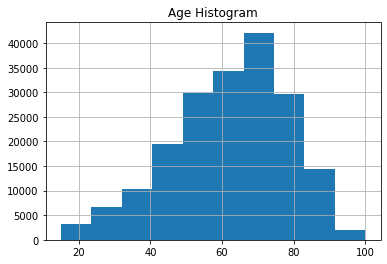

In [27]:
all_concat_data['Age'].hist()
plt.title('Age Histogram')
plt.show()

#### Gender distribution:

In [28]:
p = (100 * all_concat_data['Gender'].mean())
print(f'Precentage of male: {p:.3f}%')

Precentage of male: 55.647%


#### Scaling
In order to visualize and compare distributions of all features, we first scale them, 
using standard scaling $\frac{x_i-\mu(x)}{\sigma(x)}$.
<br> This scaling will help us next in the imputation part, and in the interpretability of linear models (weights are of the same order of magnitude).

In [29]:
scaler = StandardScaler()
rel_columns = list(vital_signs_columns) + list(lab_values_columns)
all_concat_data.loc[:, rel_columns] = scaler.fit_transform(all_concat_data[rel_columns].values)

scaler_demo = StandardScaler()
rel_columns = ['Age', 'ICULOS']
scaler_demo.fit(all_concat_data[rel_columns].values)

StandardScaler()

In [238]:
with open('pickles/scaler', 'wb') as f:
    pickle.dump(scaler, f)

with open('pickles/scaler_demo', 'wb') as f:
    pickle.dump(scaler_demo, f)

Now we can visualize all features distributions (vital signs and lab values) in the same plot.

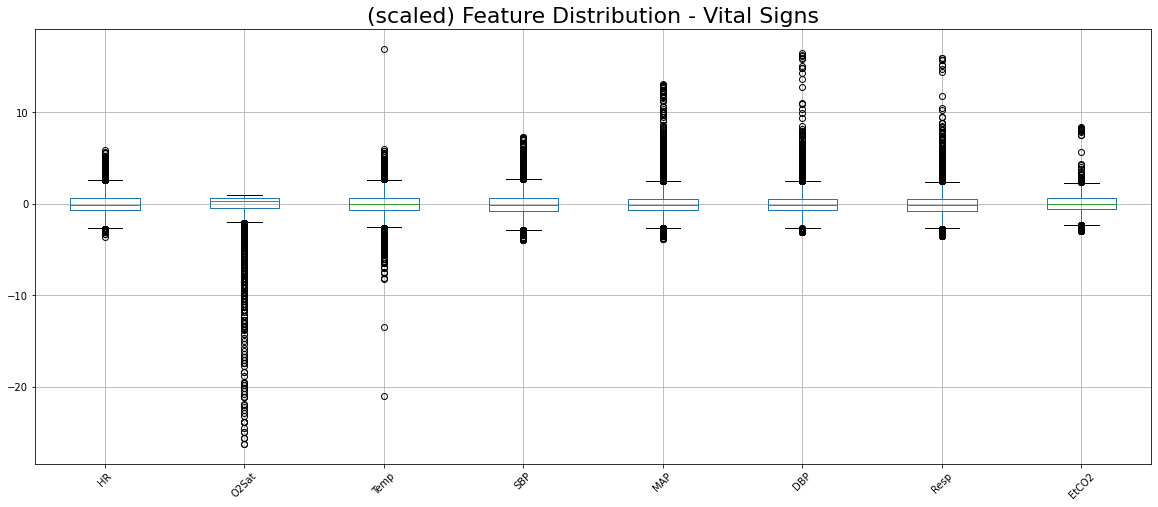

In [30]:
plt.figure(figsize=(20,8))
all_concat_data[vital_signs_columns].astype(float).boxplot()
plt.xticks(range(1, len(vital_signs_columns) + 1), vital_signs_columns, rotation=45)
plt.title('(scaled) Feature Distribution - Vital Signs', fontsize=22)
plt.show()

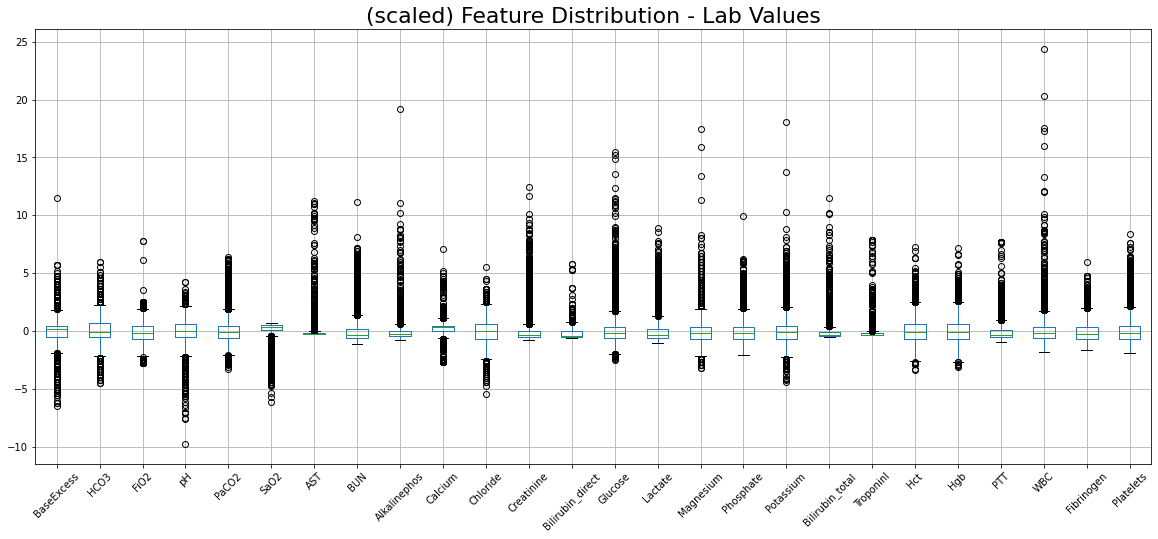

In [31]:
plt.figure(figsize=(20,8))
all_concat_data[lab_values_columns].astype(float).boxplot()
plt.xticks(range(1, len(lab_values_columns) + 1), lab_values_columns, rotation=45)
plt.title('(scaled) Feature Distribution - Lab Values', fontsize=22)
plt.show()

Notice that most features have asymmetric distributions.

## Pairwise Feature Correlations

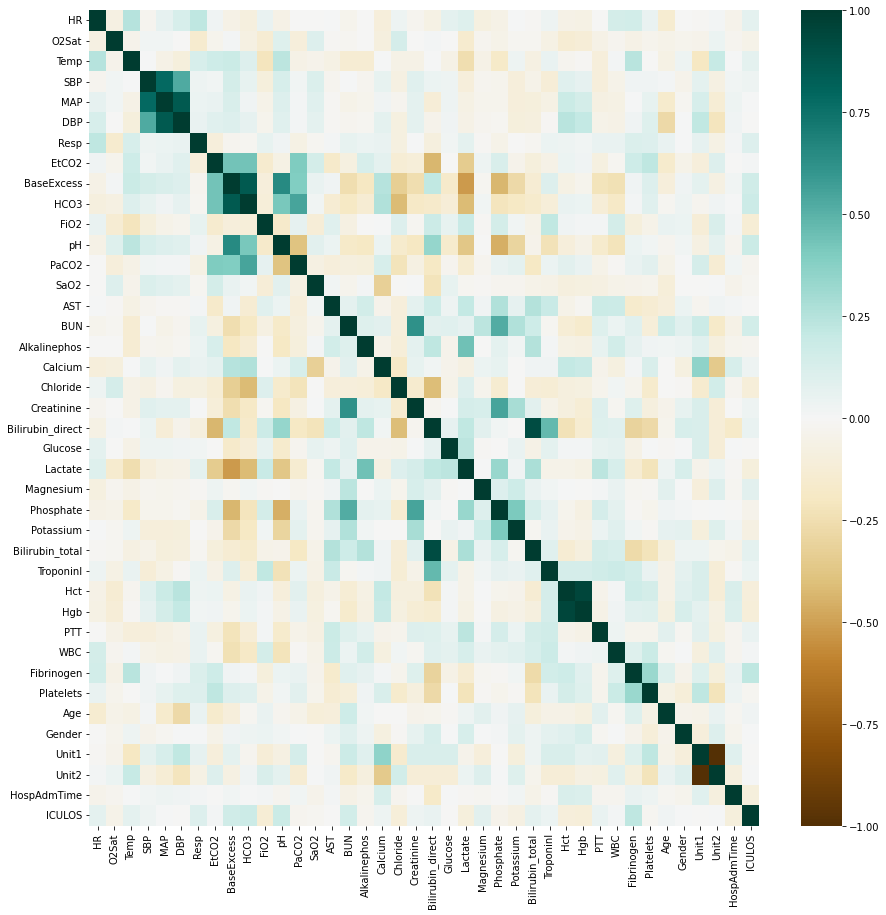

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(all_concat_data.corr(), xticklabels=all_concat_data.columns, yticklabels=all_concat_data.columns, cmap="BrBG")
plt.show()

We can observe that overall, features are not highly correlated with each other (for most $i,j$: $|\rho_{i,j}|<0.25)$.<br>
Note that the correlation between 'Unit1' and 'Unit2' is -1, which means they encode the same information, therefore we will remove 'Unit2' in preprocess.

### Correlation with time
We separately visualize the last row from the correlation matrix above, which includes the correaltion between ICULOS feature to other features. As ICULOS is the time-dimension, correlation with it is equivalent to correlation with time.

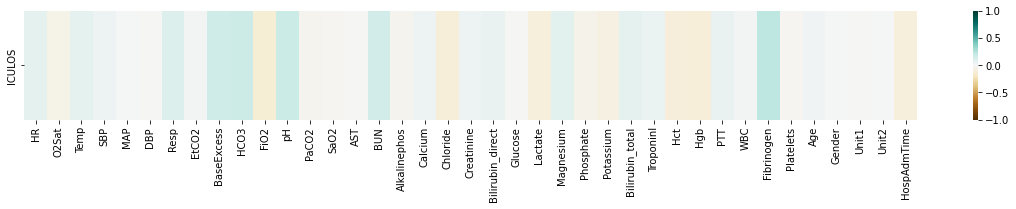

In [39]:
plt.figure(figsize=(20,2))
sns.heatmap(all_concat_data.corr().values[-1:, :-1], xticklabels=all_concat_data.columns[:-1], yticklabels=['ICULOS'], cmap="BrBG",
           vmin=-1., vmax=1.)
plt.show()

We can see that most vital signs features and demographic features are weakly correlated with time. While some lab values are correalted with time, notice that they appear rarely in the data (high precentage of missing values).
<br>Time is important, and looking at a patient through time we can get more information. However, the above result implies that time is less significant in term of feature values.
Due to the complexity of models that deal with timeseries data, and the result above, we choose to summarize and flatten the time dimension, as will be explained in the report (Feature Engineering section).

### Correlation with target

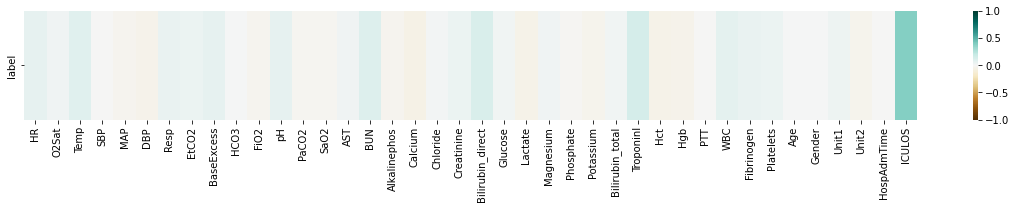

In [37]:
all_concat_data['label'] = [0] * concat_data[0].shape[0] + [1] * concat_data[1].shape[0]
plt.figure(figsize=(20,2))
sns.heatmap(all_concat_data.corr().values[-1:, :-1], xticklabels=all_concat_data.columns[:-1], yticklabels=['label'], cmap="BrBG",
           vmin=-1., vmax=1.)
all_concat_data.drop('label', axis=1, inplace=True)
plt.show()

We can see that most features have low correlation (linear relationship) with the target variable (SepsisLabel).<br>However, the ICU length-of-stay (ICULOS) is highly correlated with the sepsis label, therefore we expect it to be important in the sepsis prediction task (especially in a linear model).

### Statistical Hypothesis Testing
For each feature $j$ we test whether its distribution is equal between the two groups (SepesisLabel=0 or SepesisLabel=1):
<br>
$H_0^j: F_0^j = F_1^j$
<br>
$H_1^j: F_0^j \succ F_1^j$ or $F_0^j \prec F_1^j$
<br> where $F_0^j$ and $F_1^j$ are the CDFs for feature $j$ for the two groups by sepsis label.
<br><br>We decided to use a-parametric test (ranks sums) instead of t-test, since normallity assumption does not hold for most features. (P-values are adjusted using Bonferroni multiplicity adjustment)

In [41]:
from scipy.stats import ranksums, ttest_ind

In [45]:
p_vals = []
for col in columns[:-1]:
    _, p_val = ranksums(concat_data[0][col].astype(float).values, concat_data[1][col].astype(float).values, nan_policy='omit')
    if p_val < (0.05 / len(columns)):
        adj_pval = p_val * len(columns)
        p_vals.append((col, adj_pval))

print("Rejected hypotheses (adjusted p-values):")
for col, adj_pval in sorted(p_vals, key=lambda x: x[1]):
    print(f'{col}, {adj_pval:.3g}')

Rejected hypotheses (adjusted p-values):
ICULOS, 0
HR, 7.87e-153
HospAdmTime, 1.03e-129
Temp, 2.41e-116
Resp, 1.73e-83
DBP, 3.15e-57
BUN, 7.8e-38
O2Sat, 1.18e-35
MAP, 6.67e-33
pH, 7.95e-22
WBC, 1.83e-20
Unit1, 1.79e-19
Unit2, 1.79e-19
BaseExcess, 1.84e-14
Calcium, 1.67e-10
Hct, 4e-10
Glucose, 1.67e-08
Creatinine, 7.7e-07
Hgb, 3.43e-06
Potassium, 8.9e-06
Age, 3.54e-05
EtCO2, 0.00257
Magnesium, 0.00479
TroponinI, 0.016


We can see that about half of the hypotheses were rejected, with relatively small p-values. The low p-values can be associated with the large number of samples, which enables to be identify small differences with high confidence. 

For example, notice that the distribution of the feature 'Resp' for SepsisLabel=1 tends to larger values comapred to SepsisLabel=0:

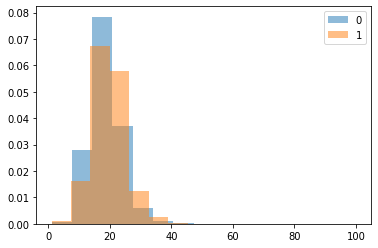

In [43]:
col = 'Resp'
col_data = {'0': concat_data[0][col].astype(float).values, '1': concat_data[1][col].astype(float).values}

plt.hist(col_data['0'], alpha=0.5, label='0', density=True, bins=15)
plt.hist(col_data['1'], alpha=0.5, label='1', density=True, bins=15)
plt.legend()
plt.show()